In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.special import erf
from xraydb import xray_line, xray_edge, material_mu
from larch.xafs.pre_edge import preedge

mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'

Correct over-absorption (self-absorption) for fluorescene XAFS
using the [FLUO alogrithm of D. Haskel](https://www3.aps.anl.gov/haskel/FLUO/Fluo-manual.pdf).
This is adapted the function from the function

from larch.xafs.fluo import fluo_corr

in the [xraylarch](https://xraypy.github.io/xraylarch/) package

This assumes
* The sample is infinitely thick
* The ratio of Auger to fluoresence effects is the same above and below the edge. This might not be true, particuarly for soft x-ray edges.
* This is a useful approach to this issue https://journals.aps.org/prb/abstract/10.1103/PhysRevB.83.081106

# Make fake data

Text(0, 0.5, 'Uncorrected fluoresence')

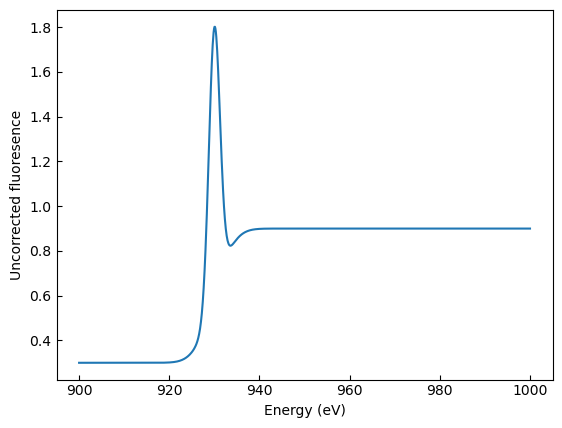

In [2]:
energy = np.linspace(900, 1000, 1000) # in eV
mu = (12*np.exp(-(energy - 930)**2/3) + 3*erf((energy - 930)/5) + 6)/10

fig, ax = plt.subplots()

ax.plot(energy, mu)
ax.set_xlabel('Energy (eV)')
ax.set_ylabel('Uncorrected fluoresence')

# Define parameters

In [3]:
formula = 'Cu2OSeO3' # string for sample stoichiometry
elem = 'Cu' # atomic symbol or Z of absorbing element
edge = 'L3' # name of edge ('K', 'L3', ...) 
anginp = 45 # incident angle in degrees w.r.t sample surface
angout = 45 # outgoing angle in degrees w.r.t sample surface
line = 'L' # emission line measured

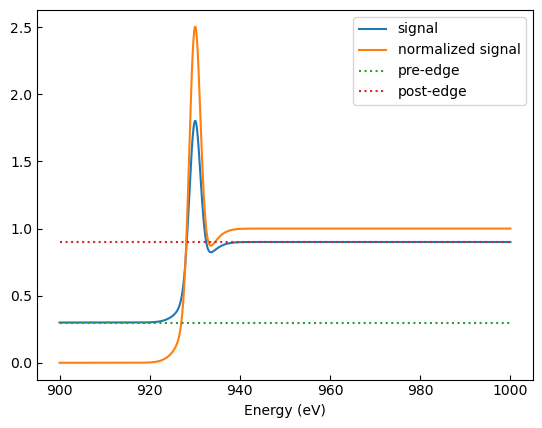

In [4]:
pre_opts = {'e0': None, 'nnorm': 1, 'nvict': 0,
            'pre1': None, 'pre2': -30,
            'norm1': 100, 'norm2': None,
            'step': None, 'nvict': 0}

# generate normalized mu for correction
preinp   = preedge(energy, mu, **pre_opts)

fig, ax = plt.subplots()

ax.plot(energy, mu, label='signal')
ax.plot(energy, preinp['norm'], label='normalized signal')
ax.plot(energy, preinp['pre_edge'], ':', label='pre-edge')
ax.plot(energy, preinp['post_edge'], ':', label='post-edge')
ax.set_xlabel('Energy (eV)')
ax.legend()

In [5]:
ang_corr = (np.sin(max(1.e-7, np.deg2rad(anginp))) /
            np.sin(max(1.e-7, np.deg2rad(angout))))

# find edge energies and fluorescence line energy
e_edge  = xray_edge(elem, edge).energy
e_fluor = xray_line(elem, line).energy

# calculate mu(E) for fluorescence energy, above, below edge

muvals = material_mu(formula, np.array([e_fluor, e_edge-10.0,
                                        e_edge+10.0]), density=1)/10**4 # inverse microns

alpha   = (muvals[0]*ang_corr + muvals[1])/(muvals[2] - muvals[1])
re_scaled = preinp['norm']*alpha/(alpha + 1 - preinp['norm']) # Yao correction

mu_scaled = (mu - mu[0])/(mu[-1] - mu[0])*(muvals[-1] - muvals[0]) + muvals[0]
mu_corr_scaled = (re_scaled - re_scaled[0])/(re_scaled[-1] - re_scaled[0])*(muvals[-1] - muvals[0]) + muvals[0]


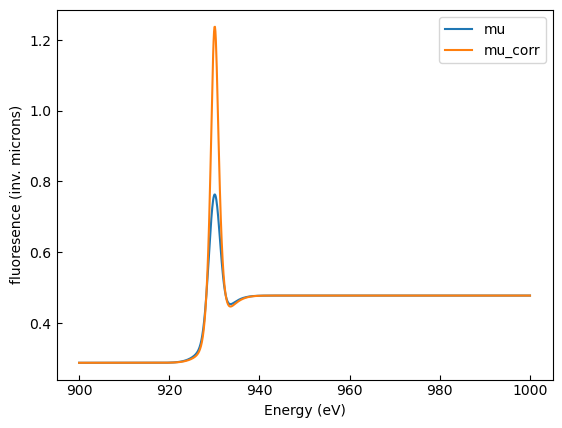

In [6]:
fig, ax = plt.subplots()

ax.plot(energy, mu_scaled, label='mu')
ax.plot(energy, mu_corr_scaled, label='mu_corr')

ax.set_xlabel('Energy (eV)')
ax.set_ylabel('fluoresence (inv. microns)')
ax.legend()